# Hurricane Track Prediction & Clustering

## Overview
This project aims to analyze and predict the movement of hurricanes in the North Atlantic (NA) region
using machine learning techniques. Specifically, we explore how ENSO (El Niño/La Niña) influences
hurricane frequency and patterns. We use IBTrACS data for hurricane tracks and NOAA's SOI dataset
for ENSO classification.

## Goals
1. Predict hurricane track shifts (latitude and longitude) using XGBoost.
2. Tune hyperparameters using RandomizedSearchCV.
3. Apply clustering (K-means) to categorize hurricane patterns.
4. Analyze how ENSO influences hurricane frequency and behavior.

## Dataset
- **IBTrACS (North Atlantic)**: Contains historical hurricane data (location, intensity, speed, direction, etc.).
- **NOAA SOI Data**: Used to classify ENSO phases (El Niño, La Niña, Neutral).

### **2. Importing Libraries**

In [21]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import requests
from io import StringIO

### **3. Loading and Processing SOI Data**

In [31]:
import requests
import pandas as pd
from io import StringIO

def process_soi_data(url):
    """
    Fetches and processes SOI (Southern Oscillation Index) data from the NOAA website.

    Steps:
    1. Retrieve the webpage content.
    2. Locate the first "YEAR" occurrence to extract only the first table (Anomaly data).
    3. Convert the text data into a pandas DataFrame.
    4. Remove invalid values (-999.9) and filter out future years (beyond 2025).
    5. Convert the dataset into a long format and compute yearly averages.
    """
    # Fetch data from NOAA website
    response = requests.get(url)
    
    # Split text by lines
    raw_text = response.text.split("\n")

    # Locate the start of the anomaly table (first occurrence of "YEAR")
    start_index = next(i for i, line in enumerate(raw_text) if "YEAR" in line)
    end_index = next(i for i, line in enumerate(raw_text[start_index+1:], start_index+1) if "YEAR" in line)  # Find second occurrence

    # Extract only the first table (Anomaly data)
    raw_data = raw_text[start_index:end_index]

    # Convert extracted data into a pandas DataFrame
    cleaned_data = "\n".join(raw_data)
    df = pd.read_csv(StringIO(cleaned_data), sep='\\s+', engine='python')

    # Ensure the correct column names
    if df.shape[1] == 13:  # Expected: Year + 12 months
        df.columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    else:
        print("Warning: Unexpected column count. Verify raw data.")

    # ✅ Remove invalid values (-999.9) that indicate missing data
    df.replace(-999.9, pd.NA, inplace=True)

    # ✅ Keep only valid years (exclude future years beyond 2025)
    df = df[df["Year"].astype(str).str.isnumeric()]  # Keep only numeric year values
    df["Year"] = df["Year"].astype(int)  # Convert to integer
    df = df[df["Year"] <= 2025]  # Filter out future years

    # Convert to long format (Month as a column instead of separate fields)
    df = df.melt(id_vars=["Year"], var_name="Month", value_name="SOI")
    
    # Convert SOI values to numeric type
    df["SOI"] = pd.to_numeric(df["SOI"], errors="coerce")

    return df

# Load and process SOI data
soi_url = "https://www.cpc.ncep.noaa.gov/data/indices/soi"
soi_data = process_soi_data(soi_url)

# Display processed data
print(soi_data.head())


   Year Month  SOI
0  1951   Jan  2.5
1  1952   Jan -1.5
2  1953   Jan  0.5
3  1954   Jan  1.1
4  1955   Jan -0.9


In [32]:
# Verify the SOI value for May 1970
may_1970 = soi_data[(soi_data["Year"] == 1970) & (soi_data["Month"] == "May")]["SOI"]
print("SOI value for May 1970:", may_1970.values)

SOI value for May 1970: [0.6]


In [33]:
# Classify ENSO Phases
def classify_enso(soi_value):
    if soi_value > 1:  # Strong positive values indicate La Niña
        return "La Niña"
    elif soi_value < -1:  # Strong negative values indicate El Niño
        return "El Niño"
    else:
        return "Neutral"

soi_data["ENSO_Phase"] = soi_data["SOI"].apply(classify_enso)

### **4. Merging SOI Data with Hurricane Data**

In [34]:
# Load NetCDF hurricane dataset
file_path = "NA_data.nc"
ds = xr.open_dataset(file_path)

In [5]:
# Extract relevant variables
time = ds["time"].values
lat = ds["lat"].values
lon = ds["lon"].values
season = ds["season"].values
storm_speed = ds["storm_speed"].values
storm_dir = ds["storm_dir"].values

In [35]:
# Convert hurricane season data into a DataFrame
hurricane_data = pd.DataFrame({"Year": season})
hurricane_counts = hurricane_data.groupby("Year").size().reset_index(name="Hurricane_Count")

# Merge hurricane count data with SOI data
enso_hurricane_data = pd.merge(hurricane_counts, soi_data, on="Year", how="left")

### **5. Visualizing ENSO Phases and Hurricane Frequency**

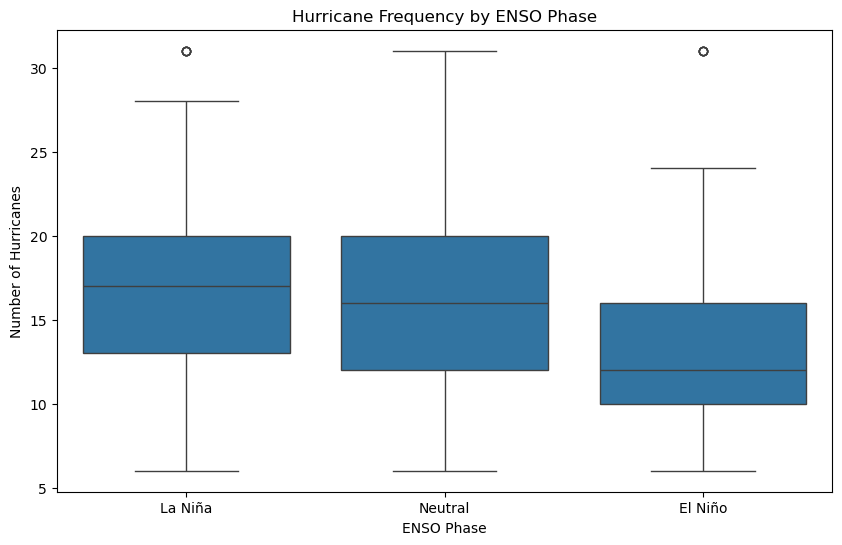

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="ENSO_Phase", y="Hurricane_Count", data=enso_hurricane_data)
plt.title("Hurricane Frequency by ENSO Phase")
plt.xlabel("ENSO Phase")
plt.ylabel("Number of Hurricanes")
plt.show()

### **6. Splitting Data into Training and Testing Sets**

In [37]:
# Goal: Split the dataset into 80% training and 20% testing to evaluate model performance.
X = np.array(hurricane_counts["Year"]).reshape(-1, 1)  # Using year as a simple predictor
y = hurricane_counts["Hurricane_Count"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### **7. Training XGBoost Model for Hurricane Prediction**

In [38]:
# Define XGBoost models
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)

# Train models
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for Hurricane Count Prediction: {mse}")

Mean Squared Error for Hurricane Count Prediction: 16.30817360828891


### **8. Hyperparameter Tuning with RandomizedSearchCV**

In [39]:
# Goal: Optimize the model parameters to improve prediction accuracy.
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=1, 
    random_state=42
)
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [10]:
# Train models
xgb_lat.fit(X_train, y_train_lat)
xgb_lon.fit(X_train, y_train_lon)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)